In [1]:
import sys
sys.path.append('C:\Program Files\Python37\Lib\site-packages')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib notebook

In [2]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=60000, shuffle=True)

In [3]:
# Convert everything to NumPy
for sample in train_loader:
    trainingSamples, labels = sample
    training = trainingSamples.numpy()
    labels = labels.numpy()

In [4]:
training = training.reshape((60000, 784))

In [5]:
# Your network architecture goes here (must be single hidden layer and not convolutional)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    def forwardNolog_softmax(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [9]:
# Load your network and get the weight vectors into NumPy arrays
network = torch.load('MNISTRegularized.pt')

params = []
for param in network.parameters():
    params.append(param.detach().numpy())
    
A1 = params[0]
b1 = params[1]
A2 = params[2]
b2 = params[3]

In [37]:
# Which output we are interested in
numToConsider = 0

In [38]:
# Get how big the weight vectors are
magnitudes = np.linalg.norm(A1, axis=1)
fullMagnitudes = np.multiply(np.abs(A2), magnitudes)

Text(0, 0.5, 'Weight magnitude sorted for output 0')

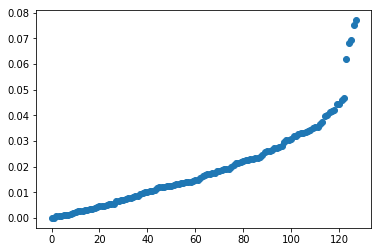

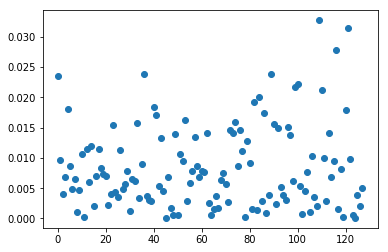

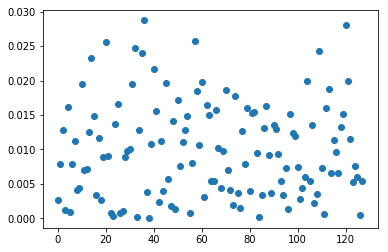

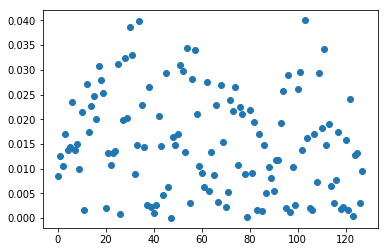

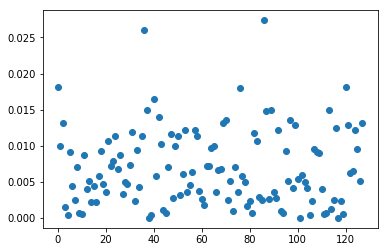

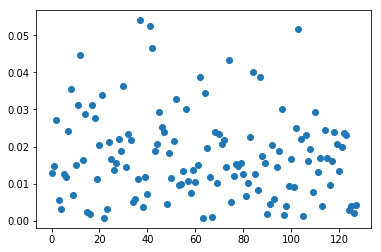

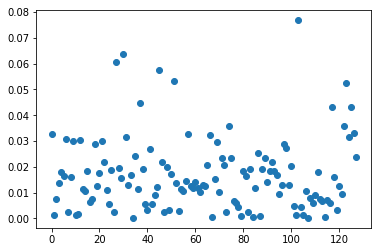

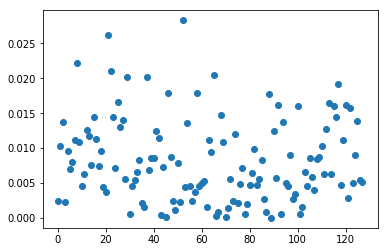

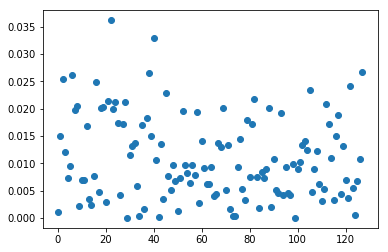

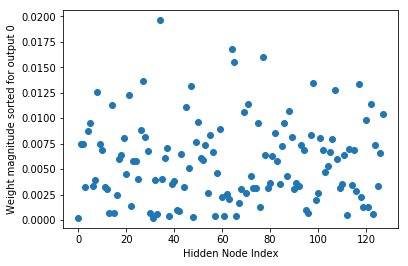

In [39]:
# Plot how big the weight vectors are, sorted by their size for the numToConsider output


indices = np.argsort(fullMagnitudes[numToConsider, :])

for i in range(10):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(fullMagnitudes[i, indices], 'o')
    
ax.set_xlabel('Hidden Node Index')
ax.set_ylabel('Weight magnitude sorted for output {}'.format(numToConsider))

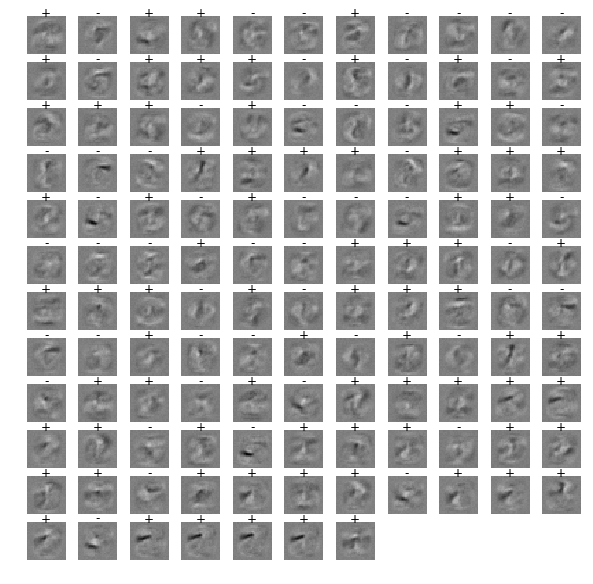

In [40]:
# Plot all of the intermediate features (hidden layer perceptrons)

fig = plt.figure(figsize=(10,10))
axs = fig.subplots(12, 11)

maxVal = -float('inf')
minVal = float('inf')

for i in range(12):
    for j in range(11):
        if i*11 + j < 128:
            im = axs[i, j].imshow(A1[indices[i*11 + j], :].reshape(28, 28), cmap='gray', interpolation='none', vmin=-0.12, vmax=0.12)
            axs[i, j].set_title('+' if A2[numToConsider, indices[i*11 + j]] > 0 else '-', pad=0)
        axs[i, j].axis('off')

In [41]:
# Look at training samples that are of the number we are considering
# see how many times each feature is used on all of the true label numToConsider
trainingSamples = training[labels==numToConsider, :]
bools = (np.matmul(A1, trainingSamples.T).T + b1) > 0
proportions = np.sum(bools, axis=0)/trainingSamples.shape[0]

Text(0, 0.5, 'Proportion used on 0')

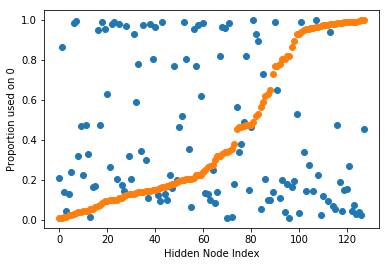

In [42]:
# Sort by usage, and plot that (orange) and the original order (blue)
fig = plt.figure()
ax = fig.add_subplot(111)
indicesProportion = np.argsort(proportions)
ax.plot(proportions[indices], 'o')
ax.plot(proportions[indicesProportion], 'o')
ax.set_xlabel('Hidden Node Index')
ax.set_ylabel('Proportion used on {}'.format(numToConsider))

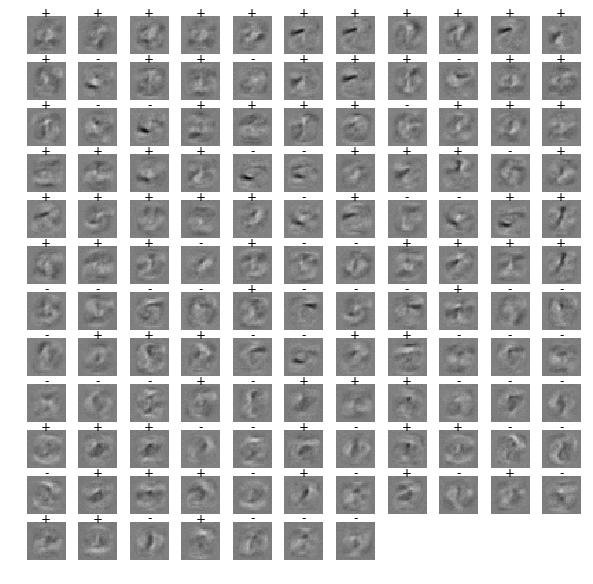

In [43]:
# Display features based on their usage for samples with true label numToConsider
fig = plt.figure(figsize=(10,10))
axs = fig.subplots(12, 11)

maxVal = -float('inf')
minVal = float('inf')

for i in range(12):
    for j in range(11):
        if i*11 + j < 128:
            im = axs[i, j].imshow(A1[indicesProportion[i*11 + j], :].reshape(28, 28), cmap='gray', interpolation='none', vmin=-0.12, vmax=0.12)
            axs[i, j].set_title('+' if A2[numToConsider, indicesProportion[i*11 + j]] > 0 else '-', pad=0)
        axs[i, j].axis('off')

In [44]:
# Calculate outputs of features
hiddens = np.matmul(A1, training.T).T + b1
hiddens[hiddens < 0] = 0
hiddens = np.matmul(A2, hiddens.T).T + b2
trainingSamples = training[labels==numToConsider, :]

In [45]:
# Which final output to consider
which = 1

In [46]:
# Calculate which features are activated
bools = (np.matmul(A1, trainingSamples[which, :].T).T + b1) > 0

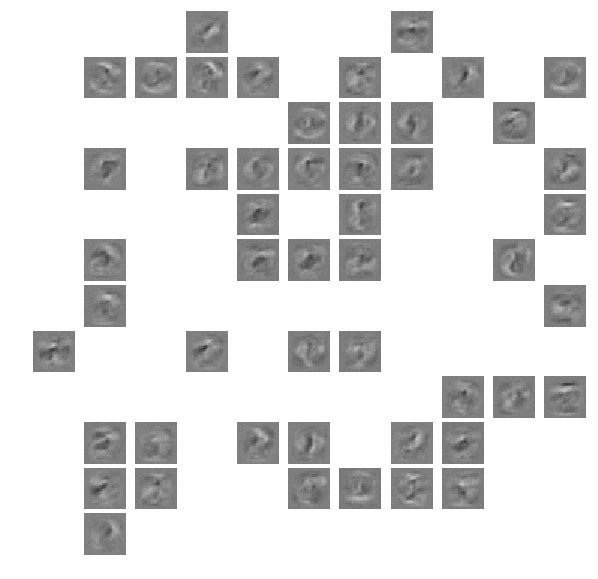

In [47]:
# Plot which features are used

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axs = fig.subplots(12, 11)

maxVal = -float('inf')
minVal = float('inf')

for i in range(12):
    for j in range(11):
        if i*11 + j < 128:
            if np.dot(A1[i*11 + j, :], trainingSamples[which, :]) + b1[i*11 + j] > 0:
                im = axs[i, j].imshow(A1[i*11 + j, :].reshape(28, 28), cmap='gray', interpolation='none', vmin=-0.12, vmax=0.12)
        axs[i, j].axis('off')

In [48]:
# Calculate the created linear region
trueWeight = np.matmul(A2[which, bools], A1[bools, :])

(-0.5, 27.5, 27.5, -0.5)

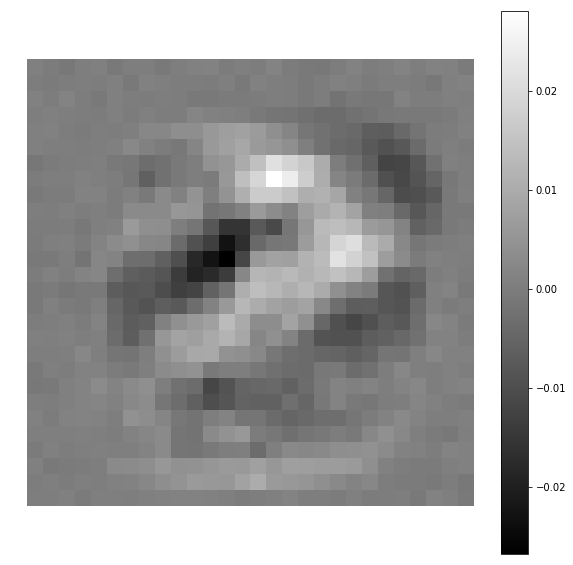

In [49]:
# Plot that linear region
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(trueWeight.reshape(28, 28), cmap='gray')
fig.colorbar(im, ax=ax)
ax.axis('off')